In [ ]:
def bulk2slab(bulk_list):
    slabs = [] # 在bulk上施加真空层
    for i in range(len(bulk_list)):
        refer_slab_ml_i = []
        refer_slab_ml_i
        for j in range(len(bulk_list[i])):
            bulk = bulk_list[i][j]
            slab = vac_ext(bulk, vacuum_h=30.0, ads_layer=4)
            refer_slab_ml_i.append(slab)
        slabs.append(refer_slab_ml_i)
        
    strain_list1 = slabs.copy()  # 不用copy会改变原本的变量
    slab_list = []
    for i in range(len(strain_list1)):
        ssl = []
        for j in range(len( strain_list1[i])):
            value = strain_list1[i][j]
            value_copy = value.copy()
            value_copy.set_constraint()
            value_copy = value_copy.repeat((4, 4, 1))
            ssl.append(value_copy)
        slab_list.append(ssl)

    return(slab_list)



In [ ]:
pre_refer_bulk_list = []
for i in range(pre_strain.shape[0]):  # 列表和字典都嵌套了两层
    print(i)
    refer_bulk_list_i = []
    for j in range(pre_strain.shape[1]):
        strain = pre_strain[i, j]
        strain_bulk, strain_real = opt_strain(bulk, strain, iscal=False)  # 先加应变
        refer_bulk_list_i.append(strain_bulk)
    pre_refer_bulk_list.append(refer_bulk_list_i)
pre_refer_bulk_dict = array2dict(pre_refer_bulk_list)

0
1
2
3
4
5
6
7
8


In [ ]:
channel_features = []
for row in molecule_name:
    temp = []
    for s in row:
        num_str = "".join(filter(str.isdigit, s))
        if num_str != "":
            temp.append(num_str)
    channel_features.append(temp)
channel_features  # 六个通道的特征

[['0', '1'],
 ['0', '12'],
 ['0', '123'],
 ['0', '012'],
 ['012', '23'],
 ['123', '02'],
 ['012', '123'],
 ['02', '13'],
 ['02', '12']]

In [ ]:
def bulk2slab(bulk_list):
    slabs = [[vac_ext(bulk, vacuum_h=30.0, ads_layer=4) for bulk in bulk_list[i]] for i in range(len(bulk_list))]

    slab_list = [slabs[i].copy() for i in range(len(slabs))]
    slab_list = [[value.copy().set_constraint().repeat((4, 4, 1)) for value in slab_list[i]] for i in range(len(slab_list))]
    return(slab_list)

In [ ]:
def bulk2slab(bulk_list):
    slabs = [[vac_ext(bulk, vacuum_h=30.0, ads_layer=4) for bulk in bulk_row] for bulk_row in bulk_list]
    slab_list = [[list(map(lambda slab: slab.copy().set_constraint().repeat((4, 4, 1)) , slab_row)) for slab_row in slabs]]
    return slab_list


经过尝试后，都不理想，放弃多重预测的想法，用直接一次预测的方式重构机器学习。

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

with open('./vasp_cal/strain.npz', 'rb') as f:
    strain = np.load(f)
# 准备数据
data = strain  # 加载数据集文件
x_train = data[:, :3]  # 输入应变数据（前三列）
y_train = data[:, 3:]  # 输出高度变化数据（最后一列）


In [ ]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(3,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3)
])

model.compile(optimizer=Adam(lr=0.0001), loss='mse')

# 训练模型
model.fit(x_train, y_train, epochs=40, batch_size=8)


In [2]:
# 使用模型进行预测

x_test = strain[:,:3] # 待预测的应变数据
predictions = model.predict(x_test)

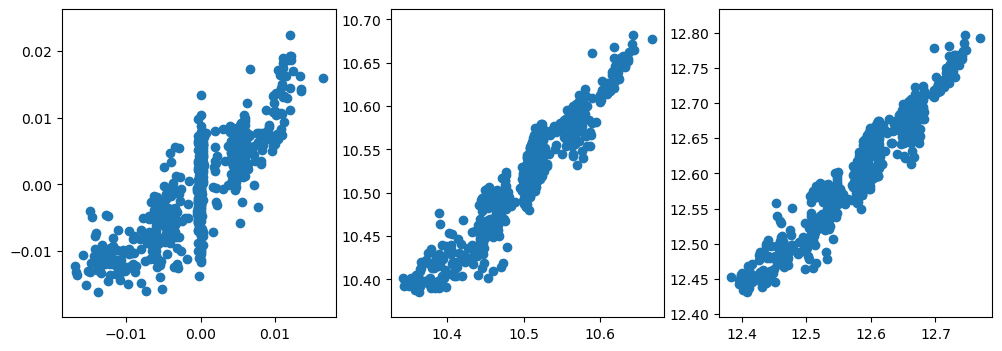

In [3]:
import matplotlib.pyplot as plt

x1 = data[:,3]
y1 = predictions[:,0]

x2 = data[:,4]
y2 = predictions[:,1]

x3 = data[:,5]
y3 = predictions[:,2]

# 计算每个数据集的最大值和最小值
y1_min, y1_max = min(y1), max(y1)
y2_min, y2_max = min(y2), max(y2)
y3_min, y3_max = min(y3), max(y3)

# 创建一个包含三个子图的画布
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# 在每个子图上绘制散点图
ax[0].scatter(x1, y1)
ax[1].scatter(x2, y2)
ax[2].scatter(x3, y3)

# 调整每个子图的y轴比例尺
ax[0].set_ylim(y1_min-0.1*(y1_max-y1_min), y1_max+0.1*(y1_max-y1_min))
ax[1].set_ylim(y2_min-0.1*(y2_max-y2_min), y2_max+0.1*(y2_max-y2_min))
ax[2].set_ylim(y3_min-0.1*(y3_max-y3_min), y3_max+0.1*(y3_max-y3_min))

# 显示图形
plt.show()


In [4]:
data.shape

(600, 6)

In [27]:
import numpy as np
import tensorflow as tf

# 定义输入和输出数据
x = x_train  # x轴应变
y = y_train[:,0]  # z轴应变预测值

# 数据预处理
x = (x - np.mean(x)) / np.std(x)  # 标准化x轴应变
y = (y - np.mean(y)) / np.std(y)  # 标准化z轴应变预测值


In [28]:
x.shape

(600, 3)

In [29]:

# 构建神经网络模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 编译模型
model.compile(loss='mean_squared_error', optimizer='adam')

# 训练模型
model.fit(x, y, epochs=20, batch_size=8)


Epoch 1/20
75/75 [==============================] - 1s 8ms/step - loss: 0.4497
Epoch 2/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0838
Epoch 3/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0852
Epoch 4/20
75/75 [==============================] - 0s 4ms/step - loss: 0.0650
Epoch 5/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0772
Epoch 6/20
75/75 [==============================] - 0s 4ms/step - loss: 0.0634
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0805
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0848
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0856
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0728
Epoch 11/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0791
Epoch 12/20
75/75 [==============================] - 0s 4ms/step - loss: 0.0740
Epoch 13/20
75/75 [==============================

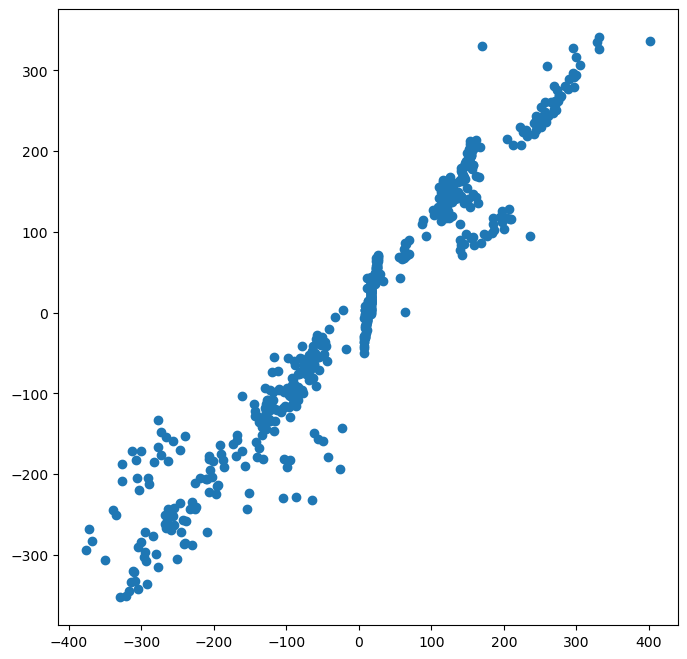

In [32]:

# 预测新的z轴应变
new_x = x_train  # 新的x轴应变
new_y = y  # 新的y轴应变
new_x = (new_x - np.mean(x_train)) / np.std(x_train)  # 标准化新的x轴应变
new_y = (new_y - np.mean(y_train[:,0])) / np.std(y_train[:,0])  # 标准化新的y轴应变
predictions = model.predict(new_x)

# 还原预测结果的标准化
predictions = predictions * np.std(new_y) + np.mean(new_y)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(new_y, predictions)


In [ ]:
new_y.shape

(600, 3)